## Checking Single Feature Predictiveness

Similar to what is done in the Social Paper, we would like to check how our network performs compared to using individual feature groups found in the network. In our case, we found that synchrony across the 4-12 Hz band in all features except the Hippocampus. We also found strong coherence factors between all Cx regions as well as between the VTA and the Nac and between the PrL_Cx and the Amygdala.

Here we train a logistic regression model on each of these feature groups and determine the multitask AUC using just those features. We then compare against the performance of our dCSFA-NMF model.

In [1]:
import sys, os
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
DATA_LOCATION = "/work/mk423/Anxiety/"
UMC_PATH = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
INFO_DICT = DATA_LOCATION + "Anx_Info_Dict.pkl"

FLX_TRAIN_FILE = DATA_LOCATION + "FLX_train_dict_old_features.pkl"
FLX_VAL_FILE = DATA_LOCATION + "FLX_validation_dict_old_features.pkl"
FLX_TEST_FILE = DATA_LOCATION + "FLX_test_dict_old_features.pkl"

EPM_TRAIN_FILE = DATA_LOCATION + "EPM_train_dict_May_17.pkl"
EPM_VAL_FILE = DATA_LOCATION + "EPM_val_dict_May_17.pkl"
EPM_TEST_FILE = DATA_LOCATION + "EPM_test_dict_May_17.pkl"

OFT_TRAIN_FILE = DATA_LOCATION + "OFT_train_dict_old_features_hand_picked.pkl"
OFT_VAL_FILE = DATA_LOCATION + "OFT_validation_dict_old_features_hand_picked.pkl"
OFT_TEST_FILE = DATA_LOCATION + "OFT_test_dict_old_features_hand_picked.pkl"

FEATURE_LIST = ['X_power_1_2','X_coh_1_2','X_gc_1_2']
FEATURE_VECTOR = FEATURE_LIST
FEATURE_WEIGHT = [10,1,1]

sys.path.append(UMC_PATH)
sys.path.append(DATA_LOCATION)

In [3]:
with open(OFT_TRAIN_FILE,'rb') as f:
    train_dict = pickle.load(f)

with open(OFT_VAL_FILE,'rb') as f:
    val_dict = pickle.load(f)

with open(OFT_TEST_FILE,'rb') as f:
    test_dict = pickle.load(f)
    
running_idx = 0
feature_groups = []
for idx,feature in enumerate(FEATURE_LIST):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in FEATURE_LIST]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])#*scale_vector
#oft_X_train[np.isnan(oft_X_train)] = 0
#oft_X_train[oft_X_train<0] = 0
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])#*scale_vector
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

oft_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
oft_y_hc_test = test_dict['y_Homecage'].astype(bool)
oft_y_task_test = ~oft_y_hc_test
oft_y_ROI_test = test_dict['y_ROI']
oft_y_vel_test = test_dict['y_vel']
oft_y_mouse_test = test_dict['y_mouse']
oft_y_time_test = test_dict['y_time']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

with open(FLX_TRAIN_FILE,"rb") as f:
    flx_train_dict = pickle.load(f)

with open(FLX_VAL_FILE,"rb") as f:
    flx_validation_dict = pickle.load(f)

with open(FLX_TEST_FILE,"rb") as f:
    flx_test_dict = pickle.load(f)

flx_X_train = np.hstack([flx_train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
flx_y_train = flx_train_dict['y_flx']
flx_y_mouse_train = flx_train_dict['y_mouse']
flx_y_expDate_train = flx_train_dict['y_expDate']
flx_y_time_train = flx_train_dict['y_time']

flx_X_validation = np.hstack([flx_validation_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
flx_y_validation = flx_validation_dict['y_flx']
flx_y_mouse_validation = flx_validation_dict['y_mouse']
flx_y_expDate_validation = flx_validation_dict['y_expDate']
flx_y_time_validation = flx_validation_dict['y_time']

flx_X_test = np.hstack([flx_test_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
flx_y_test = flx_test_dict['y_flx']
flx_y_mouse_test = flx_test_dict['y_mouse']
flx_y_expDate_test = flx_test_dict['y_expDate']
flx_y_time_test = flx_test_dict['y_time']

flx_X = np.vstack([flx_X_train,flx_X_validation])
flx_y_task = np.hstack([flx_y_train,flx_y_validation])
flx_y_mouse = np.hstack([flx_y_mouse_train,flx_y_mouse_validation])
flx_y_expDate = np.hstack([flx_y_expDate_train,flx_y_expDate_validation])
flx_y_time = np.hstack([flx_y_time_train,flx_y_time_validation])

with open(EPM_TRAIN_FILE,"rb") as f:
    epm_train_dict = pickle.load(f)

with open(EPM_VAL_FILE,"rb") as f:
    epm_validation_dict = pickle.load(f)

with open(EPM_TEST_FILE,"rb") as f:
    epm_test_dict = pickle.load(f)

#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
#X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]

X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)

X_test_task = X_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_test_task = y_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_mouse_test_task = y_mouse_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_time_test_task = y_time_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]

epm_X = np.vstack([X_train_task,X_val_task])
epm_y_task = np.hstack([y_train_task,y_val_task])
epm_y_mouse = np.hstack([y_mouse_train_task,y_mouse_val_task])
epm_y_time = np.hstack([y_time_train_task,y_time_val_task])

mt_X_train = np.vstack([flx_X_train,oft_X_train,X_train])
mt_y_train = np.hstack([flx_y_train,oft_y_task_train,y_in_task_mask_train])
mt_y_mouse_train = np.hstack([flx_y_mouse_train,oft_y_mouse_train,y_mouse_train])

mt_X_val = np.vstack([flx_X_validation,oft_X_val,X_val])
mt_y_val = np.hstack([flx_y_validation,oft_y_task_val,y_in_task_mask_val])
mt_y_mouse_val = np.hstack([flx_y_mouse_validation,oft_y_mouse_val,y_mouse_val])

mt_X_test = np.vstack([flx_X_test,oft_X_test,X_test])
mt_y_test = np.hstack([flx_y_test,oft_y_task_test,y_in_task_mask_test])
mt_y_mouse_test = np.hstack([flx_y_mouse_test,oft_y_mouse_test,y_mouse_test])

In [9]:
with open(INFO_DICT,"rb") as f:
    anx_info_dict = pickle.load(f)
    
anx_info_dict.keys()

powerFeatures = anx_info_dict['powerFeatures']

## Get power feature predictiveness

In [19]:
from sklearn.metrics import roc_auc_score

def mouse_avg_auc(y,y_pred_proba,y_mouse):
    auc_list = []
    for mouse in np.unique(y_mouse):
        mask = y_mouse==mouse
        if len(np.unique(y[mask==1])) > 1:
            auc_list.append(roc_auc_score(y[mask==1],y_pred_proba[mask==1]))
    
    return np.mean(auc_list), np.std(auc_list) / np.sqrt(len(auc_list))


freq_nums = np.array(['4','5','6','7','8','9','10','11','12','13','14'])

flx_val_mean_list = []
flx_val_std_err_list = []
epm_val_mean_list = []
epm_val_std_err_list = []
oft_val_mean_list = []
oft_val_std_err_list = []

val_data_tuples = [("flx",np.vstack((flx_X_validation,flx_X_test)),np.hstack((flx_y_validation,flx_y_test)),np.hstack((flx_y_mouse_validation,flx_y_mouse_test))),
                   ("epm",np.vstack((X_val,X_test)),np.hstack((y_in_task_mask_val,y_in_task_mask_test)),np.hstack((y_mouse_val,y_mouse_test))),
                   ("oft",np.vstack((oft_X_val,oft_X_test)),np.hstack((oft_y_task_val,oft_y_task_test)),np.hstack((oft_y_mouse_val,oft_y_mouse_test)))]

for area in anx_info_dict['area']:
    freq_check = [area + ' ' + freq for freq in freq_nums]
    feature_mask = np.array([powerFeature in freq_check for powerFeature in powerFeatures])
    x_power = mt_X_train[:,:len(powerFeatures)][:,feature_mask==1]
    lr_model = LogisticRegression().fit(x_power,mt_y_train)
    
    for experiment,x_exp_val,y_exp_val,y_mouse_exp_val in val_data_tuples:
        x_power_val = x_exp_val[:,:len(powerFeatures)][:,feature_mask==1]
        y_pred_proba = lr_model.predict_proba(x_power_val)[:,1]
        mean, std_err = mouse_avg_auc(y_exp_val,y_pred_proba,y_mouse_exp_val)
        print("{} Experiment {} AUC: {:.3f} +/- {:.3f}".format(area,experiment,mean,std_err))
        
        if experiment == "flx":
            flx_val_mean_list.append(mean)
            flx_val_std_err_list.append(std_err)
        elif experiment == "epm":
            epm_val_mean_list.append(mean)
            epm_val_std_err_list.append(std_err)
        elif experiment == "oft":
            oft_val_mean_list.append(mean)
            oft_val_std_err_list.append(std_err)

Amy Experiment flx AUC: 0.622 +/- 0.083
Amy Experiment epm AUC: 0.562 +/- 0.019
Amy Experiment oft AUC: 0.542 +/- 0.021
Cg_Cx Experiment flx AUC: 0.568 +/- 0.057
Cg_Cx Experiment epm AUC: 0.545 +/- 0.010
Cg_Cx Experiment oft AUC: 0.563 +/- 0.015
Hipp Experiment flx AUC: 0.539 +/- 0.032
Hipp Experiment epm AUC: 0.544 +/- 0.012
Hipp Experiment oft AUC: 0.518 +/- 0.014
IL_Cx Experiment flx AUC: 0.534 +/- 0.016
IL_Cx Experiment epm AUC: 0.570 +/- 0.011
IL_Cx Experiment oft AUC: 0.570 +/- 0.015
Nac Experiment flx AUC: 0.579 +/- 0.083
Nac Experiment epm AUC: 0.582 +/- 0.015
Nac Experiment oft AUC: 0.512 +/- 0.023
PrL_Cx Experiment flx AUC: 0.587 +/- 0.058
PrL_Cx Experiment epm AUC: 0.535 +/- 0.011
PrL_Cx Experiment oft AUC: 0.568 +/- 0.011
Thal Experiment flx AUC: 0.567 +/- 0.053
Thal Experiment epm AUC: 0.548 +/- 0.019
Thal Experiment oft AUC: 0.534 +/- 0.029
VTA Experiment flx AUC: 0.547 +/- 0.032
VTA Experiment epm AUC: 0.559 +/- 0.020
VTA Experiment oft AUC: 0.559 +/- 0.019


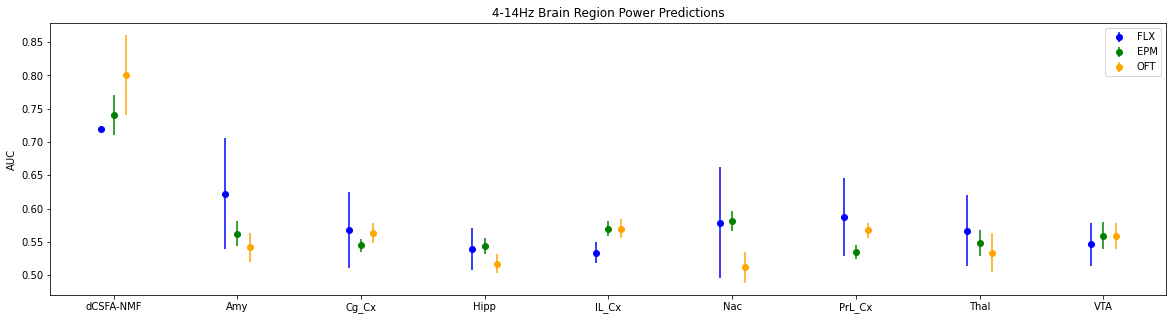

In [16]:
plt.figure(figsize=(20,5))
offset=0.1
plt.errorbar(np.arange(-1,len(flx_val_mean_list))-offset,[0.72] + flx_val_mean_list,[0] + flx_val_std_err_list,fmt="o",color="blue",label="FLX")
plt.errorbar(np.arange(-1,len(flx_val_mean_list)),[0.74] + epm_val_mean_list,[0.03]+epm_val_std_err_list,fmt="o",color="green",label="EPM")
plt.errorbar(np.arange(-1,len(flx_val_mean_list))+offset,[.8] + oft_val_mean_list,[.06] + oft_val_std_err_list,fmt="o",color="orange",label="OFT")
plt.xticks(range(-1,len(flx_val_mean_list)),["dCSFA-NMF"]+anx_info_dict['area'])
plt.ylabel("AUC")
plt.title("4-14Hz Brain Region Power Predictions")
plt.legend()
plt.savefig("/hpc/home/mk423/Anxiety/MultiTaskWork/Plots/ValDataSinglePowerFeatureComparison.png")
plt.show()

### Coherence

In [20]:
freq_nums = np.array(['4','5','6','7','8','9','10','11','12','13','14'])
coh_features = ["Amy-PrL_Cx","Nac-VTA","Cg_Cx-PrL_Cx","Cg_Cx-IL_Cx","IL_Cx-PrL_Cx"]
all_features = np.concatenate([anx_info_dict["powerFeatures"],anx_info_dict["cohFeatures"],anx_info_dict["gcFeatures"]])
coh_flx_val_mean_list = []
coh_flx_val_std_err_list = []
coh_epm_val_mean_list = []
coh_epm_val_std_err_list = []
coh_oft_val_mean_list = []
coh_oft_val_std_err_list = []

val_data_tuples = [("flx",np.vstack((flx_X_validation,flx_X_test)),np.hstack((flx_y_validation,flx_y_test)),np.hstack((flx_y_mouse_validation,flx_y_mouse_test))),
                   ("epm",np.vstack((X_val,X_test)),np.hstack((y_in_task_mask_val,y_in_task_mask_test)),np.hstack((y_mouse_val,y_mouse_test))),
                   ("oft",np.vstack((oft_X_val,oft_X_test)),np.hstack((oft_y_task_val,oft_y_task_test)),np.hstack((oft_y_mouse_val,oft_y_mouse_test)))]

for area in coh_features:
    freq_check = [area + ' ' + freq for freq in freq_nums]
    feature_mask = np.array([feature in freq_check for feature in all_features])
    x_power = mt_X_train[:,feature_mask==1]
    lr_model = LogisticRegression(max_iter=9001).fit(x_power,mt_y_train)
    
    for experiment,x_exp_val,y_exp_val,y_mouse_exp_val in val_data_tuples:
        x_power_val = x_exp_val[:,feature_mask==1]
        y_pred_proba = lr_model.predict_proba(x_power_val)[:,1]
        mean, std_err = mouse_avg_auc(y_exp_val,y_pred_proba,y_mouse_exp_val)
        print("{} Experiment {} AUC: {:.3f} +/- {:.3f}".format(area,experiment,mean,std_err))
        
        if experiment == "flx":
            coh_flx_val_mean_list.append(mean)
            coh_flx_val_std_err_list.append(std_err)
        elif experiment == "epm":
            coh_epm_val_mean_list.append(mean)
            coh_epm_val_std_err_list.append(std_err)
        elif experiment == "oft":
            coh_oft_val_mean_list.append(mean)
            coh_oft_val_std_err_list.append(std_err)

Amy-PrL_Cx Experiment flx AUC: 0.547 +/- 0.050
Amy-PrL_Cx Experiment epm AUC: 0.591 +/- 0.019
Amy-PrL_Cx Experiment oft AUC: 0.621 +/- 0.036
Nac-VTA Experiment flx AUC: 0.540 +/- 0.029
Nac-VTA Experiment epm AUC: 0.567 +/- 0.013
Nac-VTA Experiment oft AUC: 0.471 +/- 0.023
Cg_Cx-PrL_Cx Experiment flx AUC: 0.463 +/- 0.036
Cg_Cx-PrL_Cx Experiment epm AUC: 0.501 +/- 0.018
Cg_Cx-PrL_Cx Experiment oft AUC: 0.560 +/- 0.022
Cg_Cx-IL_Cx Experiment flx AUC: 0.503 +/- 0.027
Cg_Cx-IL_Cx Experiment epm AUC: 0.520 +/- 0.015
Cg_Cx-IL_Cx Experiment oft AUC: 0.546 +/- 0.021
IL_Cx-PrL_Cx Experiment flx AUC: 0.607 +/- 0.200
IL_Cx-PrL_Cx Experiment epm AUC: 0.609 +/- 0.021
IL_Cx-PrL_Cx Experiment oft AUC: 0.639 +/- 0.040


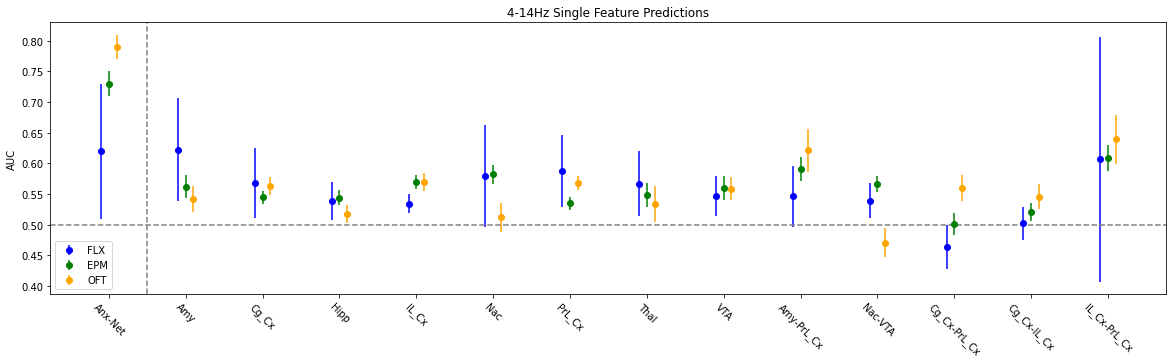

In [23]:
plt.figure(figsize=(20,5))
offset=0.1
plt.errorbar(np.arange(-1,len(coh_flx_val_mean_list)+len(flx_val_mean_list))-offset,
                       [0.62] + flx_val_mean_list + coh_flx_val_mean_list,
                       [0.11] + flx_val_std_err_list + coh_flx_val_std_err_list,fmt="o",color="blue",label="FLX")
plt.errorbar(np.arange(-1,len(coh_flx_val_mean_list)+len(flx_val_mean_list)),
                       [0.73] + epm_val_mean_list + coh_epm_val_mean_list,
                       [0.02]+epm_val_std_err_list + coh_epm_val_std_err_list,fmt="o",color="green",label="EPM")
plt.errorbar(np.arange(-1,len(coh_flx_val_mean_list)+len(flx_val_mean_list))+offset,
                       [.79] + oft_val_mean_list + coh_oft_val_mean_list,
                       [.02] + oft_val_std_err_list + coh_oft_val_std_err_list,fmt="o",color="orange",label="OFT")

plt.axvline(x=-.5,linestyle="--",color="gray")
plt.axhline(y=0.5,linestyle="--",color="gray")
plt.xticks(range(-1,len(coh_flx_val_mean_list) + len(flx_val_mean_list)),np.concatenate([["Anx-Net"],anx_info_dict["area"],coh_features]),
          rotation=-45)
plt.ylabel("AUC")
plt.title("4-14Hz Single Feature Predictions")
plt.legend(loc="lower left")
plt.savefig("/hpc/home/mk423/Anxiety/MultiTaskWork/Plots/4to14Hz_singleFeature_AUCs_vs_Network.png")
plt.show()